In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

100%|██████████| 2000/2000 [00:07<00:00, 268.77it/s]


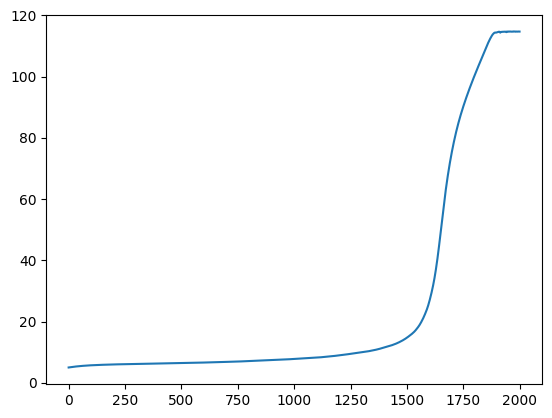

In [8]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 0.9)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 4000/4000 [00:14<00:00, 273.92it/s]


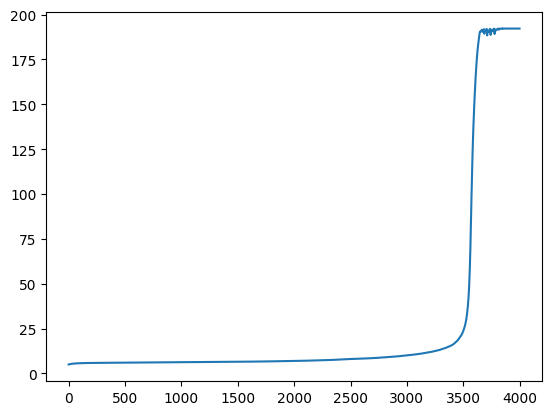

In [10]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 1.5)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=4000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 8000/8000 [00:29<00:00, 274.22it/s]


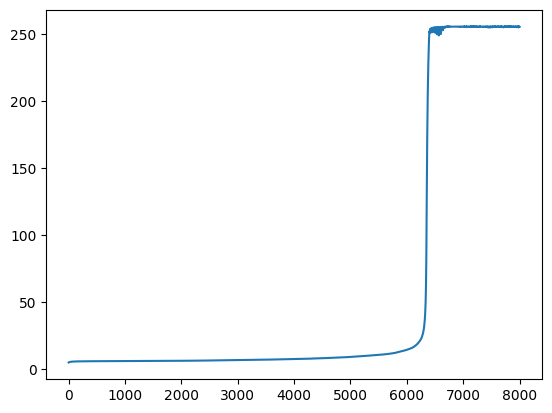

In [12]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=8000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 10000/10000 [00:38<00:00, 256.87it/s]


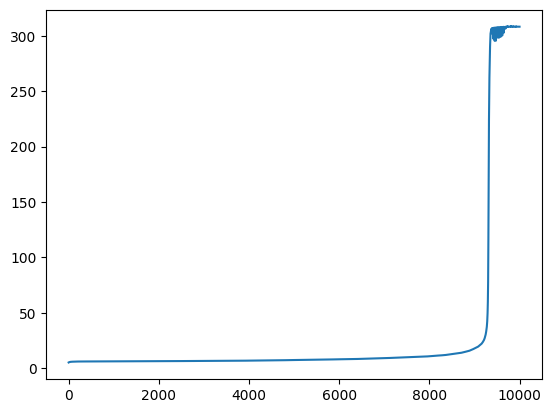

In [18]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.42)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 10000/10000 [00:36<00:00, 272.57it/s]


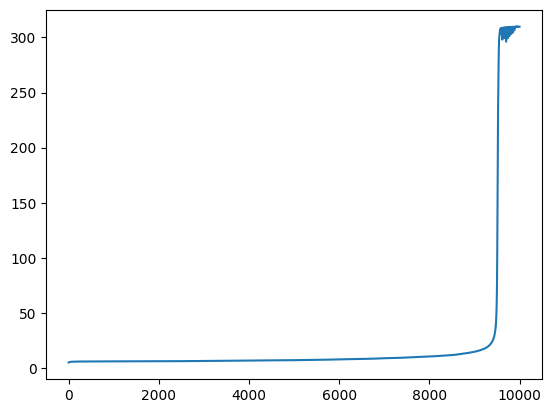

In [20]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.43)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=True)
plt.plot(method3_history)
plt.show()

In [6]:
def get_opt_alpha(model: robustness_model.ClassificationModel):
    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)
    return L3

In [7]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=False)

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [8]:
def train(sample_size=10, lr=0.001, epochs=50):

    theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs() + 1.) # theta = (0, sigma) = (sigma)
    print(theta)
    optimizer = torch.optim.Adam([theta], lr=lr)

    loss_history = []
    theta_history = []
    epsilon_history = []

    with tqdm.tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()

            dists = torch.distributions.Normal(0.0, 1)
            samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
            
            epsilons = []
            for sample in samples:
                M = sample*theta
                encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
                model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
                model.bundling(X_test, y_test) # X_train, y_train

                # epsilon = overall_robustness_method3(model, X_test) # X_train
                # epsilons.append(epsilon)
                
                # Constant Alpha
                # encoder_ = robustness_model.FHRREncoder(original_dim, dim, M=M.detach())
                # model_ = robustness_model.ClassificationModel(encoder_, in_dim=original_dim, dim=dim)
                # model_.bundling(X_test, y_test)
                model_ = model.detach()
                alpha = get_opt_alpha(model_)

                ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
                epsilons.append(ep3s.mean())

            epsilons = torch.stack(epsilons)

            # REPARAMETARIZATION TRICK
            loss = -epsilons.mean()
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())
            theta_history.append(theta.item())
            epsilon_history.append(epsilons.mean().item())

            pbar.update(1)
            pbar.set_postfix({
                'Loss': loss.item(),
                'Theta': theta.item(),
                'Epsilon': epsilons.mean().item(),
            })

    return loss_history, theta_history, epsilon_history


trial 0
Parameter containing:
tensor(3.7885, requires_grad=True)


100%|██████████| 15/15 [2:29:58<00:00, 599.93s/it, Loss=-.367, Theta=3.78, Epsilon=0.367] 


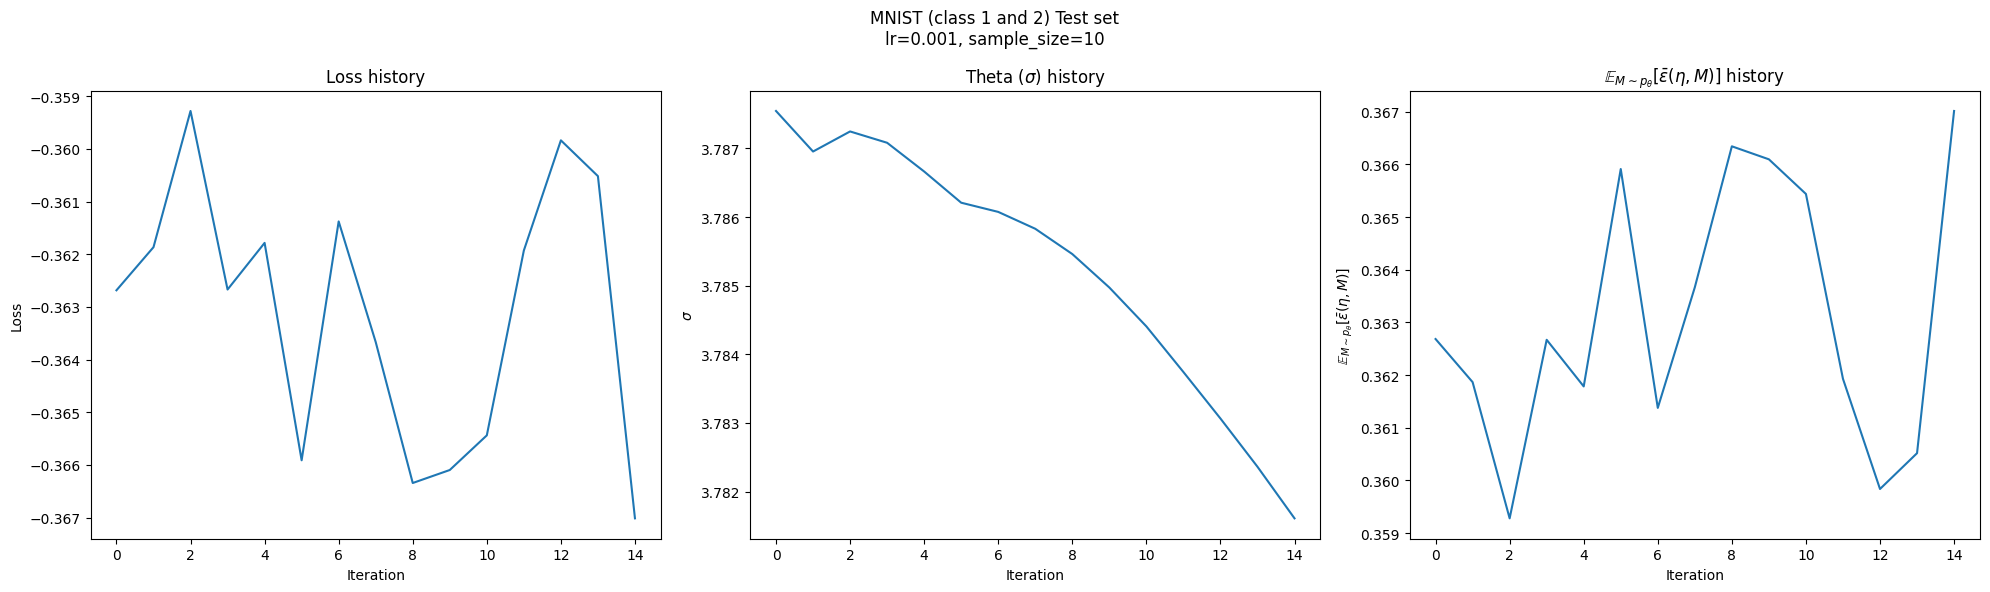

trial 1
Parameter containing:
tensor(1.4467, requires_grad=True)


100%|██████████| 15/15 [2:27:11<00:00, 588.74s/it, Loss=-.0123, Theta=1.43, Epsilon=0.0123] 


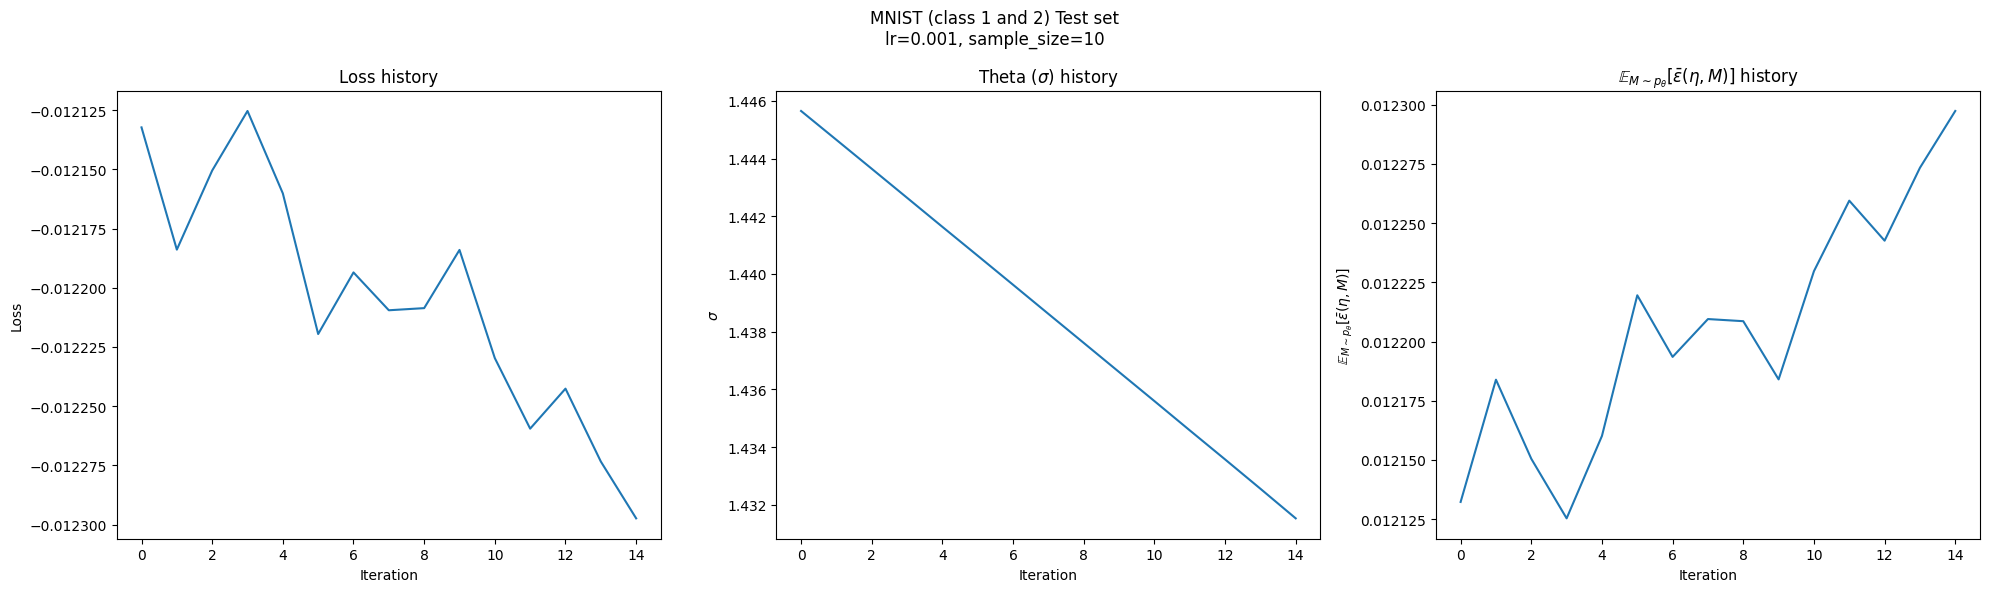

trial 2
Parameter containing:
tensor(2.0588, requires_grad=True)


100%|██████████| 15/15 [2:43:55<00:00, 655.73s/it, Loss=-.00834, Theta=2.05, Epsilon=0.00834] 


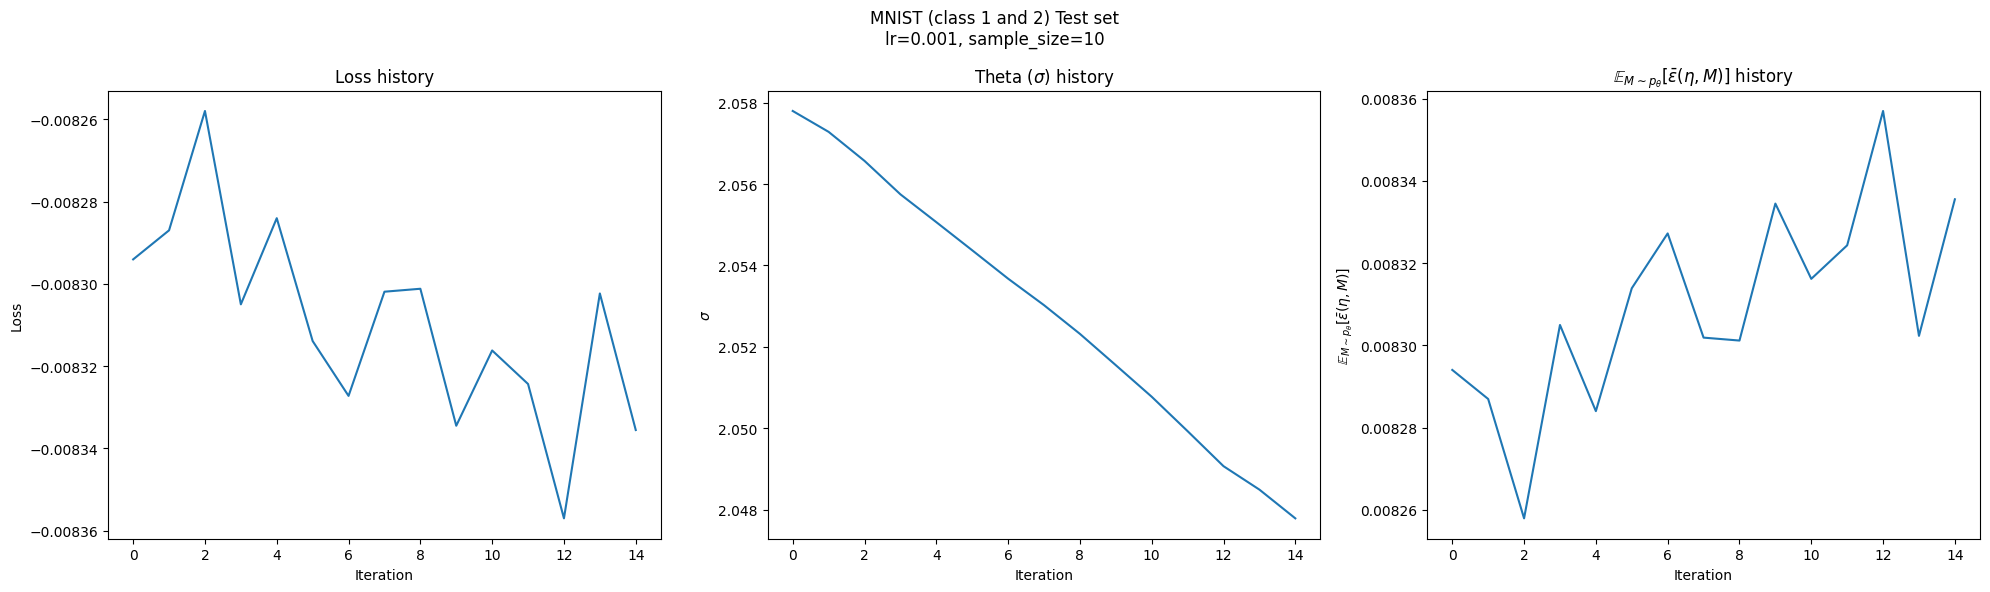

trial 3
Parameter containing:
tensor(1.3445, requires_grad=True)


100%|██████████| 15/15 [2:45:57<00:00, 663.80s/it, Loss=-.0135, Theta=1.33, Epsilon=0.0135]  


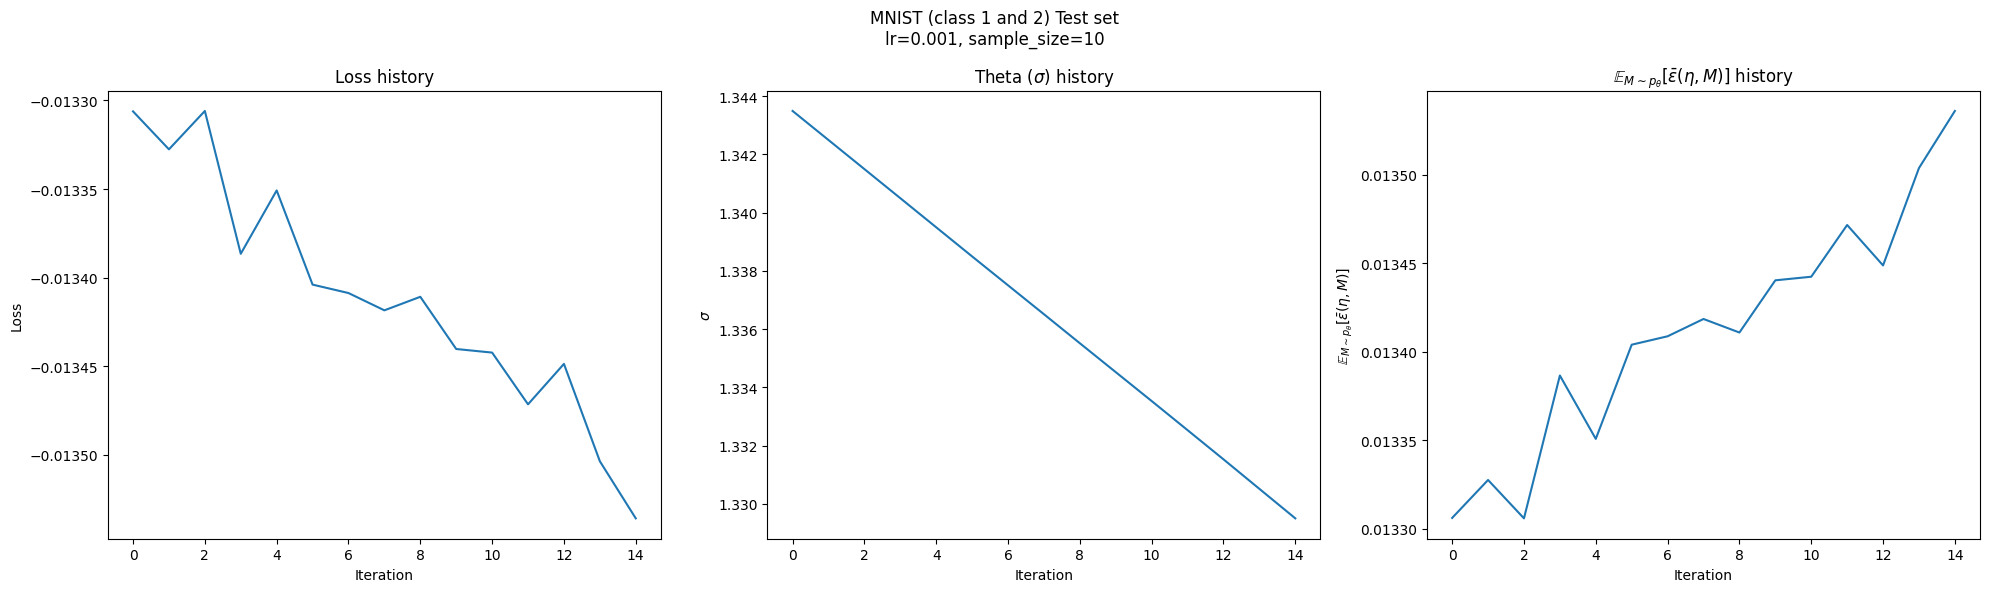

trial 4
Parameter containing:
tensor(2.0262, requires_grad=True)


 67%|██████▋   | 10/15 [1:38:47<49:59, 599.82s/it, Loss=-.00844, Theta=2.02, Epsilon=0.00844] 

In [9]:
sample_size = 10
lr = 0.001
epochs = 15

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()